In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from T2T_ACE.alignment_utilities import load_reference
import T2T_ACE.validator as v
import importlib

/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
# Update the reference genomes to local path
# I have updated the hg38 reference to primary assembly. It will address the issues with alt contigs.
class ReferenceLocations:
        hg002t2t = "/Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta"
        chm13 = "/Users/gaoyueya/Documents/Reference_Genome/chm13v2.0.fa.gz"
        hg38 = "/Users/gaoyueya/Documents/Reference_Genome/GRCh38.primary_assembly.genome.fa" # primary assembly

# Load the minimap2 aligner from reference fasta file
# Load HG002 T2T reference
hg002t2t = load_reference(ReferenceLocations.hg002t2t)
# Load hg38 reference
hg38 = load_reference(ReferenceLocations.hg38)

INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta
INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/GRCh38.primary_assembly.genome.fa.gz


In [6]:
# Load DRAGEN CNV output
HG2_DRAGEN_cnv_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1639/DRAGEN4_2_4_visualization/DRAGEN_Output/NA24385.cnv_sv.vcf"
def read_vcf(vcf_path):
    df = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    return df
HG2_DRAGEN_cnv = read_vcf(HG2_DRAGEN_cnv_path)
HG2_DRAGEN_pass_cnv = HG2_DRAGEN_cnv[HG2_DRAGEN_cnv['FILTER']=='PASS']
HG2_DRAGEN_pass_cnv.head()
# Gather all the intervals for DEL and DUP from HG2 DRAGEN PASS
DEL_pass_intervals = []
DUP_pass_intervals = []
for index, row in HG2_DRAGEN_pass_cnv.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    if row['ALT'] == '<DEL>':
        DEL_pass_intervals.append(interval)
    elif row['ALT'] == '<DUP>':
        DUP_pass_intervals.append(interval)
print('HG2 DEL intervals:',len(DEL_pass_intervals))
print('HG2 DUP intervals:',len(DUP_pass_intervals))

HG2 DEL intervals: 996
HG2 DUP intervals: 115


In [120]:
importlib.reload(v)

<module 'T2T_ACE.validator' from '/Users/gaoyueya/Documents/GitHub/T2T-ACE/T2T_ACE/validator.py'>

In [121]:
# Testing collect_del_flankings function in validator.py
v.collect_del_flankings("chr1:212910885-212912827", ReferenceLocations.hg38, hg38, hg002t2t)

flanking_size: 1000
left flanking interval: chr1:212909885-212910885, 1001, 1, 2
right flanking interval: chr1:212912827-212913827, 1001, 1, 2
********** Potential DEL **********
chr1_MATERNAL:207785826-207786859 (1034bp), chr1_MATERNAL:207786859-207787873 (1015bp), -1
********** Potential DEL **********
chr1_PATERNAL:215948837-215949870 (1034bp), chr1_PATERNAL:215949870-215950884 (1015bp), -1


{'del_interval': 'chr1:212910885-212912827',
 'del_interval_size': 1943,
 'flanking_size': 1000,
 'left_flanking_interval': 'chr1:212909885-212910885',
 'right_flanking_interval': 'chr1:212912827-212913827',
 'left_flanking_hg38_hits': 1,
 'right_flanking_hg38_hits': 1,
 'left_flanking_hg2_hits': 2,
 'right_flanking_hg2_hits': 2,
 'distance_between_flankings': [-1, -1],
 'flanking_connection_strand': ['POS', 'POS']}

In [98]:
v.align_interval('chr1:212910691-212910885', ReferenceLocations.hg38, hg38, hg002t2t)[1]

[['chr15_MATERNAL:34168333-34168528', 1, 0, 195],
 ['chr15_PATERNAL:29598494-29598689', 1, 0, 195],
 ['chr1_PATERNAL:215949675-215949870', 1, 0, 195],
 ['chr1_MATERNAL:207786664-207786859', 1, 0, 195],
 ['chr8_MATERNAL:80220113-80220308', -1, 0, 195],
 ['chr8_PATERNAL:80341539-80341734', -1, 0, 195]]

In [79]:
# This function is to calculate distance between DEL flankings
def distance_between_flankings(del_interval, flanking_size=None):
    chr, pos, end = v.parse_interval(del_interval)
    svlen = v.interval_size(del_interval)
    
    # Create flanking intervals for the deletion interval
    # The flanking size is 10% of the SV length
    if flanking_size:
        flanking_size = flanking_size
    else:
        if svlen < 1000:
            flanking_size = 1000
        else:
            flanking_size = int(svlen * 0.1)
    # initiate of flanking intervals        
    left_flanking_hg2_alignment_intervals = []
    right_flanking_hg2_alignment_intervals = []
    left_flanking_interval_aligned = []

    while len(left_flanking_hg2_alignment_intervals) < 2 or len(right_flanking_hg2_alignment_intervals)<2:
        print(f"flanking_size: {flanking_size}")
        left_flanking_pos = pos - flanking_size
        left_flanking_end = pos 
        right_flanking_pos = end
        right_flanking_end = end + flanking_size
        
        left_flanking_interval = v.create_interval(chr, left_flanking_pos, left_flanking_end)
        right_flanking_interval = v.create_interval(chr, right_flanking_pos, right_flanking_end)
        
        # Align the flanking intervals to the reference genome
        left_flanking_interval_aligned = v.align_interval(left_flanking_interval, ReferenceLocations.hg38, hg38, hg002t2t)
        right_flanking_interval_aligned = v.align_interval(right_flanking_interval, ReferenceLocations.hg38, hg38, hg002t2t)
        
        left_flanking_hg38_alignment_intervals = [interval for interval, strand, q_start, q_end in left_flanking_interval_aligned[0]]
        right_flanking_hg38_alignment_intervals = [interval for interval, strand, q_start, q_end in right_flanking_interval_aligned[0]]
        
        # Grab intervals of flanking region alignments in HG2
        left_flanking_hg2_alignment_intervals = [interval for interval, strand, q_start, q_end in left_flanking_interval_aligned[1]]
        right_flanking_hg2_alignment_intervals = [interval for interval, strand, q_start, q_end in right_flanking_interval_aligned[1]]
        
        # Print out the flanking intervals, their sizes, and the number of alignments in HG002
        print(f"left flanking interval: {left_flanking_interval}, {v.interval_size(left_flanking_interval)}, {len(left_flanking_hg38_alignment_intervals)}, {len(left_flanking_hg2_alignment_intervals)}")
        print(f"right flanking interval: {right_flanking_interval}, {v.interval_size(right_flanking_interval)}, {len(right_flanking_hg38_alignment_intervals)}, {len(right_flanking_hg2_alignment_intervals)}")
        
        # Increase the flanking size by 1000bp if there is less than two alignments in HG002
        # 1000 is arbitrary. But it seems to work well for most of the cases.
        flanking_size = flanking_size + 1000
    
    distance_between_flankings_list = []
    for left_flanking_interval, strand, q_start, q_end in left_flanking_interval_aligned[1]:
        if strand ==1:
            matching_right_flanking_interval = v.find_next_interval(left_flanking_interval, right_flanking_hg2_alignment_intervals)
            if matching_right_flanking_interval:
                distance_between_flankings = v.distance_between_intervals(left_flanking_interval, matching_right_flanking_interval)
                distance_between_flankings_list.append(distance_between_flankings)
                if distance_between_flankings < int(svlen) * 0.5:
                    print('********** Potential DEL **********')
                else:
                    print("----------- No DEL Evidence -----------")
                print(f"{left_flanking_interval} ({v.interval_size(left_flanking_interval)}bp), {matching_right_flanking_interval} ({v.interval_size(matching_right_flanking_interval)}bp), {distance_between_flankings}")
            else:
                print(f"No matching right flanking interval for {left_flanking_interval}")
        elif strand == -1:
            matching_right_flanking_interval = v.find_previous_interval(left_flanking_interval, right_flanking_hg2_alignment_intervals)
            distance_between_flankings = v.distance_between_intervals(left_flanking_interval, matching_right_flanking_interval)
            distance_between_flankings_list.append(distance_between_flankings)
            if distance_between_flankings < int(svlen) * 0.5:
                print('********** Potential DEL**********')
            else:
                print("----------- No DEL Evidence -----------")
            print(f"{left_flanking_interval} ({v.interval_size(left_flanking_interval)}bp), {matching_right_flanking_interval} ({v.interval_size(matching_right_flanking_interval)}bp), {distance_between_flankings}")

    return distance_between_flankings_list


In [80]:
def classify_del(del_interval, flanking_size=None): 
    chr, pos, end = v.parse_interval(del_interval)
    svlen = v.interval_size(del_interval)
    print(del_interval, svlen)
    distance_between_flankings_list = distance_between_flankings(del_interval, flanking_size)
    if chr == 'chrY' or chr == 'chrX':
        if len(distance_between_flankings_list) == 2 and min(distance_between_flankings_list) <= svlen*0.5:
            return 'Homozygous DEL'
        elif len(distance_between_flankings_list)>0 and min(distance_between_flankings_list) <= svlen*0.5:
            return 'Heterozygous DEL'
        else:
            return 'Unknown'
    elif len(distance_between_flankings_list) > 2 and min(distance_between_flankings_list) <= svlen*0.5:
        return 'Complex DEL'
    elif len(distance_between_flankings_list) == 2 and distance_between_flankings_list[0] <= svlen*0.5 and distance_between_flankings_list[1] <= svlen*0.5:
        return 'Homozygous DEL'
    elif len(distance_between_flankings_list) == 2 and min(distance_between_flankings_list) <= svlen*0.5:
        return 'Heterozygous DEL'
    else:
        return 'Unknown'


In [81]:
# Example 1: Homozygous deletion (Needs basepair correction)
classify_del(DEL_pass_intervals[0])

chr1:934321-934937 617
flanking_size: 1000
left flanking interval: chr1:933321-934321, 1001, 1, 2
right flanking interval: chr1:934937-935937, 1001, 1, 2
********** Potential DEL **********
chr1_MATERNAL:366927-367768 (842bp), chr1_MATERNAL:367706-368706 (1001bp), -63
********** Potential DEL **********
chr1_PATERNAL:367566-368407 (842bp), chr1_PATERNAL:368345-369345 (1001bp), -63


'Homozygous DEL'

In [82]:
# Example 2: Heterozygous deletion (No basepair correction is needed)
classify_del(DEL_pass_intervals[1])

chr1:1934923-1935584 662
flanking_size: 1000
left flanking interval: chr1:1933923-1934923, 1001, 1, 2
right flanking interval: chr1:1935584-1936584, 1001, 1, 2
----------- No DEL Evidence -----------
chr1_MATERNAL:1371206-1372207 (1002bp), chr1_MATERNAL:1372867-1373870 (1004bp), 659
********** Potential DEL **********
chr1_PATERNAL:1377138-1378207 (1070bp), chr1_PATERNAL:1378207-1379207 (1001bp), -1


'Heterozygous DEL'

In [83]:
# Example 3: Het deletion with complex structure (Needs basepair correction)
classify_del(DEL_pass_intervals[2])

chr1:1934989-1935584 596
flanking_size: 1000
left flanking interval: chr1:1933989-1934989, 1001, 1, 2
right flanking interval: chr1:1935584-1936584, 1001, 1, 2
----------- No DEL Evidence -----------
chr1_MATERNAL:1371272-1372273 (1002bp), chr1_MATERNAL:1372867-1373870 (1004bp), 593
********** Potential DEL **********
chr1_PATERNAL:1377204-1378225 (1022bp), chr1_PATERNAL:1378207-1379207 (1001bp), -19


'Heterozygous DEL'

In [256]:
# Classify all the DELs by DRAGEN with collect_del_flankings function in validator.py

def classify_list_of_DELs(DEL_intervals):
    del_sum_df = pd.DataFrame()
    del_interval_list = []
    del_interval_size_list = []
    flanking_size_list = []
    left_flanking_interval_list = []
    right_flanking_interval_list = []
    left_flanking_hg38_hits_list = []
    right_flanking_hg38_hits_list = []
    left_flanking_hg2_hits_list = []
    right_flanking_hg2_hits_list = []
    distance_between_flankings_list = []
    flanking_connection_strand_list = []
    major_classification_list = []
    minor_classification_list = []
    for interval in DEL_intervals:
        print(interval)
        sum_dict = v.collect_del_flankings(interval, ReferenceLocations.hg38, hg38, hg002t2t)
        del_interval_list.append(sum_dict['del_interval'])
        del_interval_size_list.append(sum_dict['del_interval_size'])
        flanking_size_list.append(sum_dict['flanking_size'])
        left_flanking_interval_list.append(sum_dict['left_flanking_interval'])
        right_flanking_interval_list.append(sum_dict['right_flanking_interval'])
        left_flanking_hg38_hits_list.append(sum_dict['left_flanking_hg38_hits'])
        right_flanking_hg38_hits_list.append(sum_dict['right_flanking_hg38_hits'])
        left_flanking_hg2_hits_list.append(sum_dict['left_flanking_hg2_hits'])
        right_flanking_hg2_hits_list.append(sum_dict['right_flanking_hg2_hits'])
        distance_between_flankings_list.append(sum_dict['distance_between_flankings'])
        flanking_connection_strand_list.append(sum_dict['flanking_connection_strand'])
        major_classification_list.append(sum_dict['classification'])
        minor_classification_list.append(sum_dict['minor_classification'])
    del_sum_df['del_interval'] = del_interval_list
    del_sum_df['del_interval_size'] = del_interval_size_list
    del_sum_df['flanking_size'] = flanking_size_list
    del_sum_df['left_flanking_interval'] = left_flanking_interval_list
    del_sum_df['right_flanking_interval'] = right_flanking_interval_list
    del_sum_df['left_flanking_hg38_hits'] = left_flanking_hg38_hits_list
    del_sum_df['right_flanking_hg38_hits'] = right_flanking_hg38_hits_list
    del_sum_df['left_flanking_hg2_hits'] = left_flanking_hg2_hits_list
    del_sum_df['right_flanking_hg2_hits'] = right_flanking_hg2_hits_list
    del_sum_df['distance_between_flankings'] = distance_between_flankings_list
    del_sum_df['flanking_connection_strand'] = flanking_connection_strand_list
    del_sum_df['major_classification'] = major_classification_list
    del_sum_df['minor_classification'] = minor_classification_list
    return del_sum_df
    

In [340]:
importlib.reload(v)
HG2_DRAGEN_DEL_sum_df = classify_list_of_DELs(DEL_pass_intervals)
HG2_DRAGEN_DEL_sum_df.head()

chr1:934321-934937
flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:932321-934321, 2001, 1, 2
right flanking interval: chr1:934937-936937, 2001, 1, 2
********** Potential DEL **********
chr1_MATERNAL:365931-367768 (1838bp), chr1_MATERNAL:367706-369667 (1962bp), -63
********** Potential DEL **********
chr1_PATERNAL:366570-368407 (1838bp), chr1_PATERNAL:368345-370306 (1962bp), -63
chr1:1934923-1935584
flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:1932923-1934923, 2001, 1, 2
right flanking interval: chr1:1935584-1937584, 2001, 1, 2
----------- No DEL Evidence -----------
chr1_MATERNAL:1370206-1372207 (2002bp), chr1_MATERNAL:1372867-1374870 (2004bp), 659
********** Potential DEL **********
chr1_PATERNAL:1376138-1378207 (2070bp), chr1_PATERNAL:1378207-1380208 (2002bp), -1
chr1:1934989-1935584
flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:1932989-1934989, 2001, 1, 2
right flanking interval: chr1:1935584-1937584, 2001, 1, 2
------

,del_interval,del_interval_size,flanking_size,left_flanking_interval,right_flanking_interval,left_flanking_hg38_hits,right_flanking_hg38_hits,left_flanking_hg2_hits,right_flanking_hg2_hits,distance_between_flankings,flanking_connection_strand,major_classification,minor_classification
0,chr1:934321-934937,617,2000,chr1:932321-934321,chr1:934937-936937,1,1,2,2,"[-63, -63]","[POS, POS]",DEL,Homozygous DEL
1,chr1:1934923-1935584,662,2000,chr1:1932923-1934923,chr1:1935584-1937584,1,1,2,2,"[659, -1]","[POS, POS]",DEL,Heterozygous DEL
2,chr1:1934989-1935584,596,2000,chr1:1932989-1934989,chr1:1935584-1937584,1,1,2,2,"[593, -19]","[POS, POS]",DEL,Heterozygous DEL
3,chr1:2122128-2124374,2247,2000,chr1:2120128-2122128,chr1:2124374-2126374,1,1,2,2,"[2648, 1701]","[POS, POS]",False DEL,False DEL
4,chr1:6006003-6006574,572,2000,chr1:6004003-6006003,chr1:6006574-6008574,1,1,2,2,"[1178, 75]","[POS, POS]",DEL,Heterozygous DEL


In [341]:
HG2_DRAGEN_DEL_sum_df.to_csv('./HG2_DRAGEN_DEL_sum_df.csv', index=False)

In [362]:
[(i,v.interval_size(i)) for i in DEL_pass_intervals if 'chr2:888' in i]

[('chr2:88832599-89017488', 184890),
 ('chr2:88832768-89234182', 401415),
 ('chr2:88832769-88859609', 26841)]

In [364]:
# Testing/troubleshooting cell
importlib.reload(v)
v.collect_del_flankings('chr2:88832599-89017488', ReferenceLocations.hg38, hg38, hg002t2t)  

flanking_size: 55467, copy_threshold: 2
left flanking interval: chr2:88777132-88832599, 55468, 1, 2
right flanking interval: chr2:89017488-89072955, 55468, 2, 2
----------- No DEL Evidence -----------
chr2_MATERNAL:88800487-88855942 (55456bp), chr2_MATERNAL:90349757-90405284 (55528bp), 1493814
----------- No DEL Evidence -----------
chr2_PATERNAL:88812943-88868403 (55461bp), chr2_PATERNAL:90274988-90330517 (55530bp), 1406584


{'del_interval': 'chr2:88832599-89017488',
 'del_interval_size': 184890,
 'flanking_size': 55467,
 'left_flanking_interval': 'chr2:88777132-88832599',
 'right_flanking_interval': 'chr2:89017488-89072955',
 'left_flanking_hg38_hits': 1,
 'right_flanking_hg38_hits': 2,
 'left_flanking_hg2_hits': 2,
 'right_flanking_hg2_hits': 2,
 'distance_between_flankings': [1493814, 1406584],
 'flanking_connection_strand': ['POS', 'POS'],
 'classification': 'False DEL',
 'minor_classification': 'False DEL'}

In [352]:
import T2T_ACE.duplication_evaluation as duplication_evaluation
duplication_evaluation.eval_dup_interval("chr7:38346551-38364943", ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).analyzeDuplicationIntervals()

----------------------------------------------------------------
Alignment Report of Original Interval
----------------------------------------------------------------
input dup interval: chr7:38346551-38364943
hg38 dup count: 1
interval: chr7:38346550-38364943	strand: 1, start: 0, end: 18393
hg2 dup count: 1
interval: chr7_MATERNAL:38454519-38472908	strand: 1, start: 0, end: 18393
The DUP interval's classification is Copy Neutral and it will not be corrected
----------------------------------------------------------------
End of Analysis of DUP interval chr7:38346551-38364943(18393bp)
----------------------------------------------------------------


{'dup_interval': 'chr7:38346551-38364943',
 'dup_interval_size': 18393,
 'original_hg38_hit_count': 1,
 'original_hg2_hit_count': 1,
 'original_hg2_mat_hit_count': 1,
 'original_hg2_pat_hit_count': 0,
 'original_dup_interval_major_classification': 'Copy Neutral',
 'original_dup_interval_sub_classification': 'Maternal Copy Neutral',
 'original_dup_interval_contain_big_gap': False,
 'corrected_interval': nan,
 'corrected_interval_size': nan,
 'expanded_length': nan,
 'corrected_hg38_hit_count': nan,
 'corrected_hg2_hit_count': nan,
 'corrected_hg2_mat_hit_count': nan,
 'corrected_hg2_pat_hit_count': nan,
 'corrected_dup_interval_major_classification': nan,
 'corrected_dup_interval_sub_classification': nan,
 'corrected_pos_accuracy': nan,
 'corrected_end_accuracy': nan}

In [346]:
HG2_DRAGEN_DEL_sum_df['minor_classification'].value_counts().reindex(['Homozygous DEL', 'Heterozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown'])

minor_classification
Homozygous DEL      310
Heterozygous DEL    607
DEL in DUP            7
Unclassified DEL      1
False DEL            60
Unknown              11
Name: count, dtype: int64

In [356]:
HG2_DRAGEN_DEL_sum_df[HG2_DRAGEN_DEL_sum_df['minor_classification']=='Unknown'].iloc[0]

del_interval                  chr2:88832769-88859609
del_interval_size                              26841
flanking_size                                  27052
left_flanking_interval        chr2:88805717-88832769
right_flanking_interval       chr2:88859609-88886661
left_flanking_hg38_hits                            1
right_flanking_hg38_hits                           1
left_flanking_hg2_hits                             2
right_flanking_hg2_hits                            0
distance_between_flankings              [None, None]
flanking_connection_strand              [None, None]
major_classification                         Unknown
minor_classification                         Unknown
Name: 107, dtype: object

In [347]:
HG2_DRAGEN_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown'])

major_classification
DEL          925
False DEL     60
Unknown       11
Name: count, dtype: int64

/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

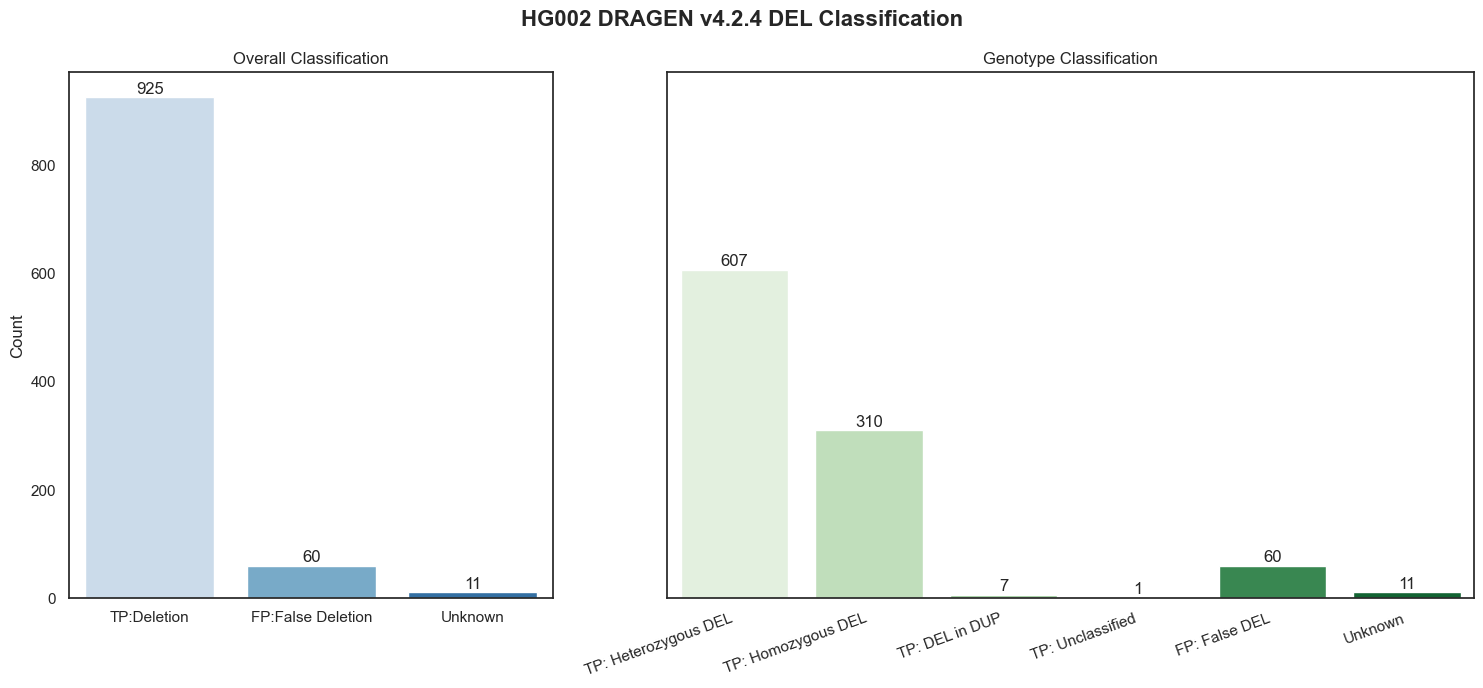

In [444]:
# Plot the performance of DRAGEN DEL classification
sns.set(style='white')

# Annotate the unknown classification
maj_classifications = ['TP:Deletion', 'FP:False Deletion', 'Unknown']
maj_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown']))['count'].tolist()
sub_classifications = ['TP: Heterozygous DEL', 'TP: Homozygous DEL', 'TP: DEL in DUP','TP: Unclassified', 'FP: False DEL', 'Unknown']
sub_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['minor_classification'].value_counts().reindex(['Heterozygous DEL', 'Homozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown']))['count'].tolist()

f, (ax0, ax1) = plt.subplots(nrows= 1, ncols= 2, figsize=(15,7), sharey=True, gridspec_kw={'width_ratios': [1.2, 2]})
maj_bar = sns.barplot(x=maj_classifications, y=maj_count, ax=ax0, palette='Blues')
ax0.set_xlabel('')
ax0.set_ylabel('Count')
ax0.set_title('Overall Classification', fontsize=12)


sub_bar = sns.barplot(x=sub_classifications, y=sub_count, ax=ax1, palette='Greens')
ax1.set_xlabel('')
ax1.set_title('Genotype Classification', fontsize=12)

plt.xticks(rotation=20, ha='right')

# Annotations for major classifications
for i, count in enumerate(maj_count):
    maj_bar.text(i, count + 1, str(count), ha='center', va='bottom')

# Annotations for sub classifications
for i, count in enumerate(sub_count):
    sub_bar.text(i, count + 1, str(count), ha='center', va='bottom')

plt.suptitle('HG002 DRAGEN v4.2.4 DEL Classification', fontsize=16, fontweight='bold')
plt.tight_layout()

plt.savefig('HG002_DRAGEN_DEL_Classification.png', dpi=300)

In [ ]:
#TODO: chr6:32657114-32658082 is a real HET DEL. However, T2T-ACE is not able to detect it. Need to figure out why.

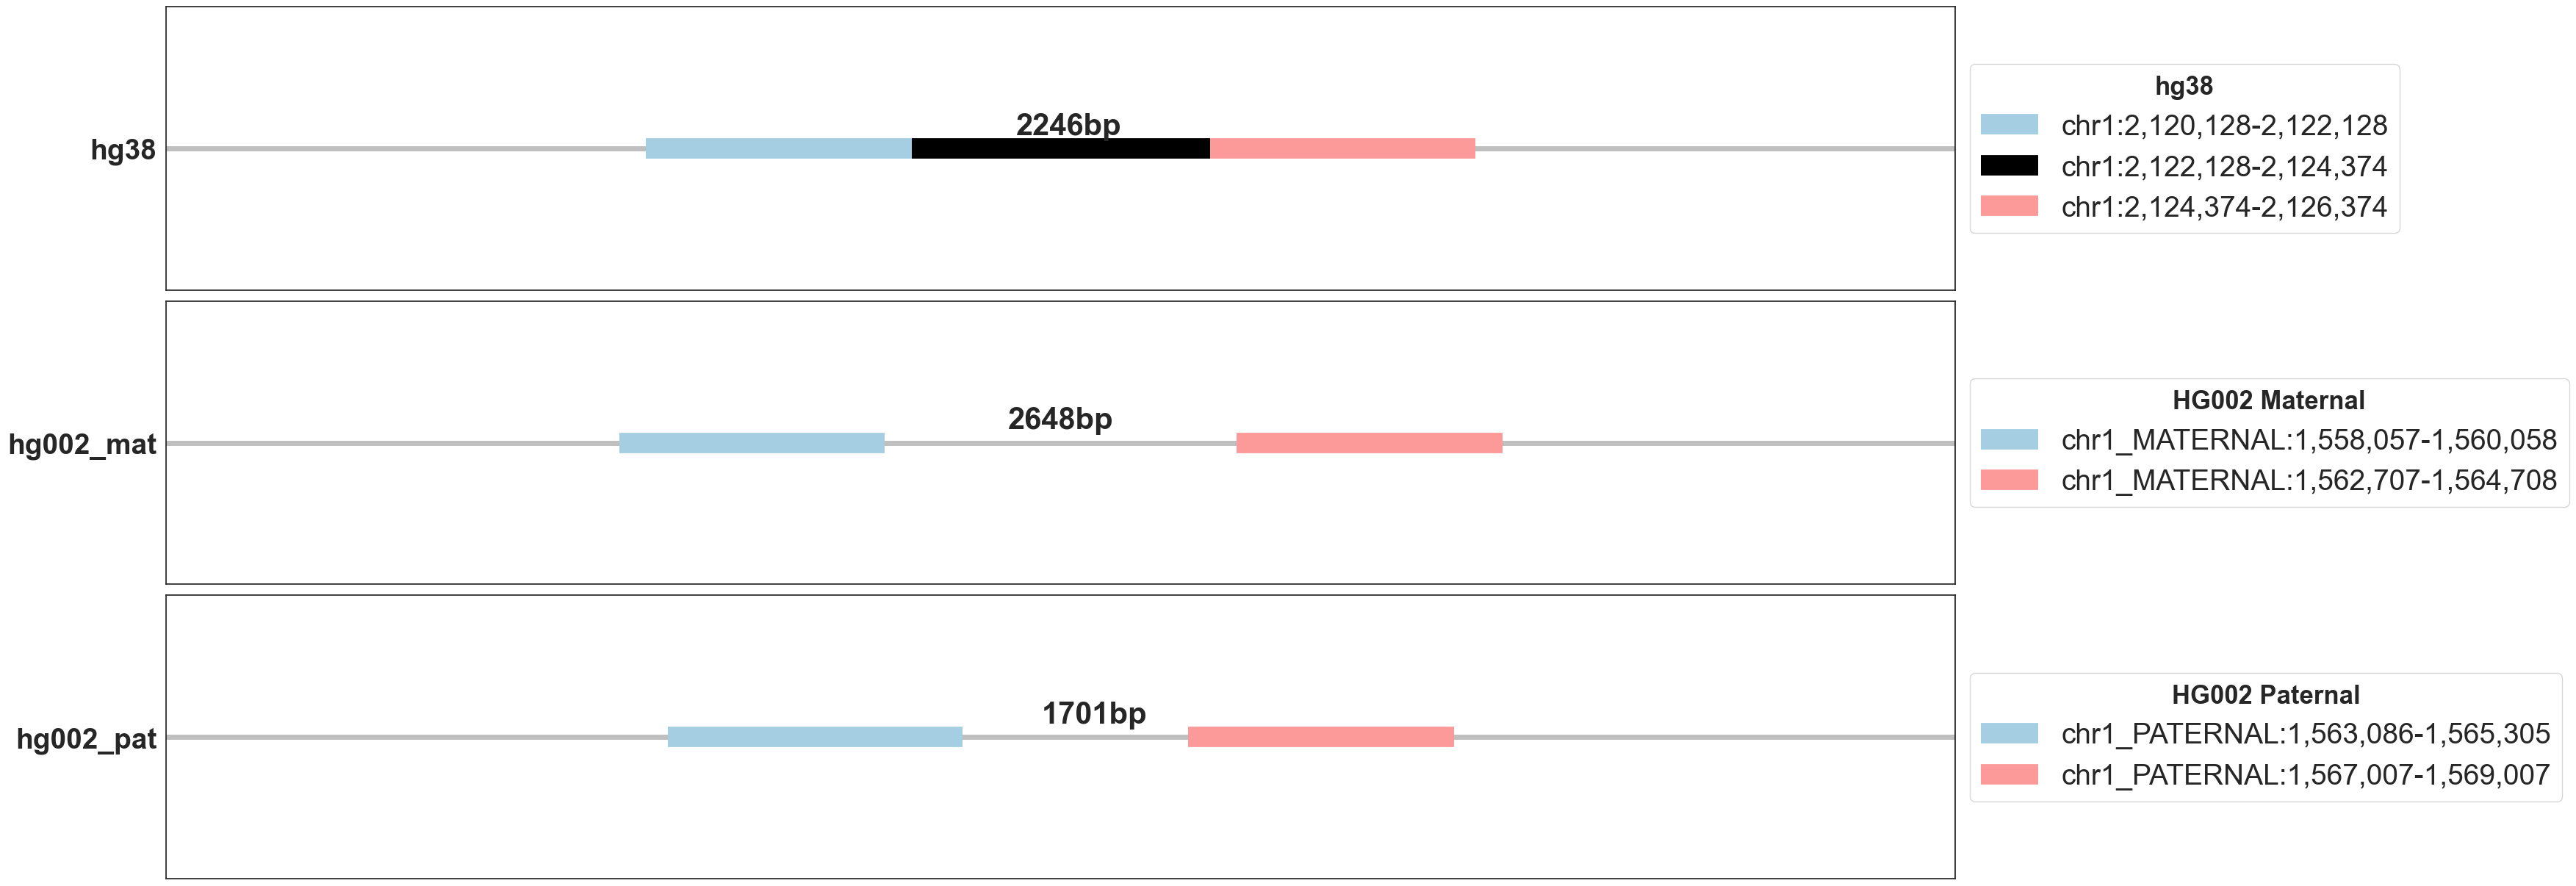

In [166]:
import T2T_ACE.alignment_visualization_utilities as avu
importlib.reload(avu)
avu.PlotIntervals(["chr1:2122128-2124374", "chr1:2120128-2122128", "chr1:2124374-2126374"], ["chr1_MATERNAL:1558057-1560058","chr1_MATERNAL:1562707-1564708","chr1_PATERNAL:1563086-1565305", "chr1_PATERNAL:1567007-1569007"]).plot_intervals_comparison(flanking=True, save=True, savepath='/Users/gaoyueya/Documents/GitHub/T2T-ACE/docs/')

In [ ]:
# WEEKLY DEV GOAL
# TODO: 1. Analyze the complex DELs. So far, it seems like the complex DELs are DEL in DUP. I want to check if this is true. 
# TODO: 2. Check if all unknown DELs are FPs. If not FPs, what are they?
# TODO: 3. Develop basepair correction for DELs.
# TODO: 4. The current basepair correction mechanism seems to have flaws. The extended copies are overlapping with each other. Need to fix this.

In [368]:
# prepare GATK-SV DEL output
HG2_GATK_SV_vcf_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1818/GATK-SV-HG002/GATK-SV_HG002_single_sample.vcf"
HG2_GATK_SV_df = read_vcf(HG2_GATK_SV_vcf_path)
HG2_GATK_SV_pass_df = HG2_GATK_SV_df[HG2_GATK_SV_df['FILTER']=='PASS']
HG2_GATK_SV_pass_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
29,chr1,1565630,NA24385.chr1.final_cleanup_DUP_chr1_20,G,<DUP>,999,PASS,ALGORITHMS=wham;BOTHSIDES_SUPPORT;CHR2=chr1;EN...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,"0/1:79:3:2:0:99:1:79:RD,SR"
30,chr1,1667010,NA24385.chr1.final_cleanup_DEL_chr1_14,C,<DEL>,999,PASS,ALGORITHMS=manta;BOTHSIDES_SUPPORT;CHR2=chr1;E...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,"0/1:2:1:9:0:99:1:2:RD,SR"
33,chr1,1948936,NA24385.chr1.final_cleanup_INS_chr1_2,C,<INS>,359,PASS,ALGORITHMS=manta;CHR2=chr1;END=1948984;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,0/1:63:.:.:0:99:1:63:SR
36,chr1,2121513,NA24385.chr1.final_cleanup_DEL_chr1_16,T,<DEL>,884,PASS,ALGORITHMS=manta;CHR2=chr1;END=2121638;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,0/1:43:4:3:0:99:1:43:SR
38,chr1,2211684,NA24385.chr1.final_cleanup_DUP_chr1_25,T,<DUP>,802,PASS,ALGORITHMS=manta;CHR2=chr1;END=2212195;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,"0/1:0:3:12:1:0:0:0:RD,PE"


In [373]:
# Make sure there is no 0/0 genotype in the DEL calls
set([row['SAMPLE'].split(':')[0] for index, row in HG2_GATK_SV_pass_df.iterrows() if row['ALT']=='<DEL>'])

{'0/1', '1/1'}

In [374]:
# Make sure there is no 0/0 genotype in the DUP calls
set([row['SAMPLE'].split(':')[0] for index, row in HG2_GATK_SV_pass_df.iterrows() if row['ALT']=='<DUP>'])

{'0/1', '1/1'}

In [387]:
# Collect all the PASS DEL intervals from GATK-SV
HG2_GATK_SV_pass_DEL_list = []
HG2_GATK_SV_pass_DUP_list = []

for index, row in HG2_GATK_SV_pass_df.iterrows():
    if row['ALT']=='<DEL>' and int(row['INFO'].split('SVLEN=')[1].split(';')[0]) > 500:
        interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
        HG2_GATK_SV_pass_DEL_list.append(interval)
    elif row['ALT']=='<DUP>' and int(row['INFO'].split('SVLEN=')[1].split(';')[0]) > 1000:
        interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
        HG2_GATK_SV_pass_DUP_list.append(interval)
        


In [391]:
print('GATK-SV DEL: ', len(HG2_GATK_SV_pass_DEL_list))
print('GATK-SV DUP: ', len(HG2_GATK_SV_pass_DUP_list))

GATK-SV DEL:  721
GATK-SV DUP:  86


In [392]:
importlib.reload(v)
HG2_GATKSV_DEL_sum_df = classify_list_of_DELs(HG2_GATK_SV_pass_DEL_list)
HG2_GATKSV_DEL_sum_df.head()

chr1:14109813-14111746
flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:14107813-14109813, 2001, 1, 2
right flanking interval: chr1:14111746-14113746, 2001, 1, 1
flanking_size: 3000, copy_threshold: 2
left flanking interval: chr1:14106813-14109813, 3001, 1, 2
right flanking interval: chr1:14111746-14114746, 3001, 1, 2
----------- No DEL Evidence -----------
chr1_MATERNAL:13750422-13753423 (3002bp), chr1_MATERNAL:13755354-13758355 (3002bp), 1930
********** Potential DEL **********
chr1_PATERNAL:13667286-13670283 (2998bp), chr1_PATERNAL:13670283-13673363 (3081bp), -1
chr1:14110579-14112444
flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:14108579-14110579, 2001, 1, 2
right flanking interval: chr1:14112444-14114444, 2001, 1, 2
----------- No DEL Evidence -----------
chr1_MATERNAL:13752188-13754189 (2002bp), chr1_MATERNAL:13756052-13758053 (2002bp), 1862
********** Potential DEL **********
chr1_PATERNAL:13669048-13671063 (2016bp), chr1_PATERNAL:1367106

,del_interval,del_interval_size,flanking_size,left_flanking_interval,right_flanking_interval,left_flanking_hg38_hits,right_flanking_hg38_hits,left_flanking_hg2_hits,right_flanking_hg2_hits,distance_between_flankings,flanking_connection_strand,major_classification,minor_classification
0,chr1:14109813-14111746,1934,3000,chr1:14106813-14109813,chr1:14111746-14114746,1,1,2,2,"[1930, -1]","[POS, POS]",DEL,Heterozygous DEL
1,chr1:14110579-14112444,1866,2000,chr1:14108579-14110579,chr1:14112444-14114444,1,1,2,2,"[1862, -3]","[POS, POS]",DEL,Heterozygous DEL
2,chr1:14331216-14331990,775,2000,chr1:14329216-14331216,chr1:14331990-14333990,1,1,2,2,"[-3, 772]","[POS, POS]",DEL,Heterozygous DEL
3,chr1:24478055-24480950,2896,2000,chr1:24476055-24478055,chr1:24480950-24482950,1,1,2,2,"[-10, 2893]","[POS, POS]",DEL,Heterozygous DEL
4,chr1:25259164-25265164,6001,2000,chr1:25257164-25259164,chr1:25265164-25267164,1,2,2,4,"[5998, 5998]","[POS, POS]",False DEL,False DEL


In [393]:
HG2_GATKSV_DEL_sum_df['major_classification'].value_counts()

major_classification
DEL          640
False DEL     75
Unknown        6
Name: count, dtype: int64

In [394]:
HG2_GATKSV_DEL_sum_df['minor_classification'].value_counts()

minor_classification
Heterozygous DEL    431
Homozygous DEL      204
False DEL            75
Unknown               6
DEL in DUP            5
Name: count, dtype: int64

In [395]:
HG2_GATKSV_DEL_sum_df.to_csv('./HG2_GATKSV_DEL_sum_df.csv', index=False)

In [420]:
# Plot the performance of GATK-SV vs DRAGEN DEL classification

maj_classifications = ['TP:Deletion', 'FP:False Deletion', 'Unknown']
gakt_sv_maj_count = pd.DataFrame(HG2_GATKSV_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown']))['count'].tolist()
dragen_maj_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown']))['count'].tolist()
sub_classifications = ['TP: Heterozygous DEL', 'TP: Homozygous DEL', 'TP: DEL in DUP','TP: Unclassified', 'FP: False DEL', 'Unknown']
gatk_sv_sub_count = pd.DataFrame(HG2_GATKSV_DEL_sum_df['minor_classification'].value_counts().reindex(['Heterozygous DEL', 'Homozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown']))['count'].tolist()
dragen_sub_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['minor_classification'].value_counts().reindex(['Heterozygous DEL', 'Homozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown']))['count'].tolist()


In [433]:
GATK_SV_maj_count_df = pd.DataFrame({'Count':gakt_sv_maj_count,'Caller':["GATK-SV v4.2.6.1"]*3}, index=maj_classifications)
GATK_dragen_maj_count_df = pd.DataFrame({'Count':dragen_maj_count,'Caller':["DRAGEN v4.2.4"]*3}, index=maj_classifications)
maj_count_df = pd.concat([GATK_SV_maj_count_df, GATK_dragen_maj_count_df], axis=0)
maj_count_df.head()

,Count,Caller
TP:Deletion,640,GATK-SV v4.2.6.1
FP:False Deletion,75,GATK-SV v4.2.6.1
Unknown,6,GATK-SV v4.2.6.1
TP:Deletion,925,DRAGEN v4.2.4
FP:False Deletion,60,DRAGEN v4.2.4


In [439]:
# Replace NAN with 0
gatk_sv_sub_count[3] = 0

In [440]:
GATK_SV_sub_count_df = pd.DataFrame({'Count':gatk_sv_sub_count,'Caller':["GATK-SV v4.2.6.1"]*6}, index=sub_classifications)
GATK_dragen_sub_count_df = pd.DataFrame({'Count':dragen_sub_count,'Caller':["DRAGEN v4.2.4"]*6}, index=sub_classifications)
sub_count_df = pd.concat([GATK_SV_sub_count_df, GATK_dragen_sub_count_df], axis=0)
sub_count_df

,Count,Caller
TP: Heterozygous DEL,431.0,GATK-SV v4.2.6.1
TP: Homozygous DEL,204.0,GATK-SV v4.2.6.1
TP: DEL in DUP,5.0,GATK-SV v4.2.6.1
TP: Unclassified,0.0,GATK-SV v4.2.6.1
FP: False DEL,75.0,GATK-SV v4.2.6.1
Unknown,6.0,GATK-SV v4.2.6.1
TP: Heterozygous DEL,607.0,DRAGEN v4.2.4
TP: Homozygous DEL,310.0,DRAGEN v4.2.4
TP: DEL in DUP,7.0,DRAGEN v4.2.4
TP: Unclassified,1.0,DRAGEN v4.2.4


/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

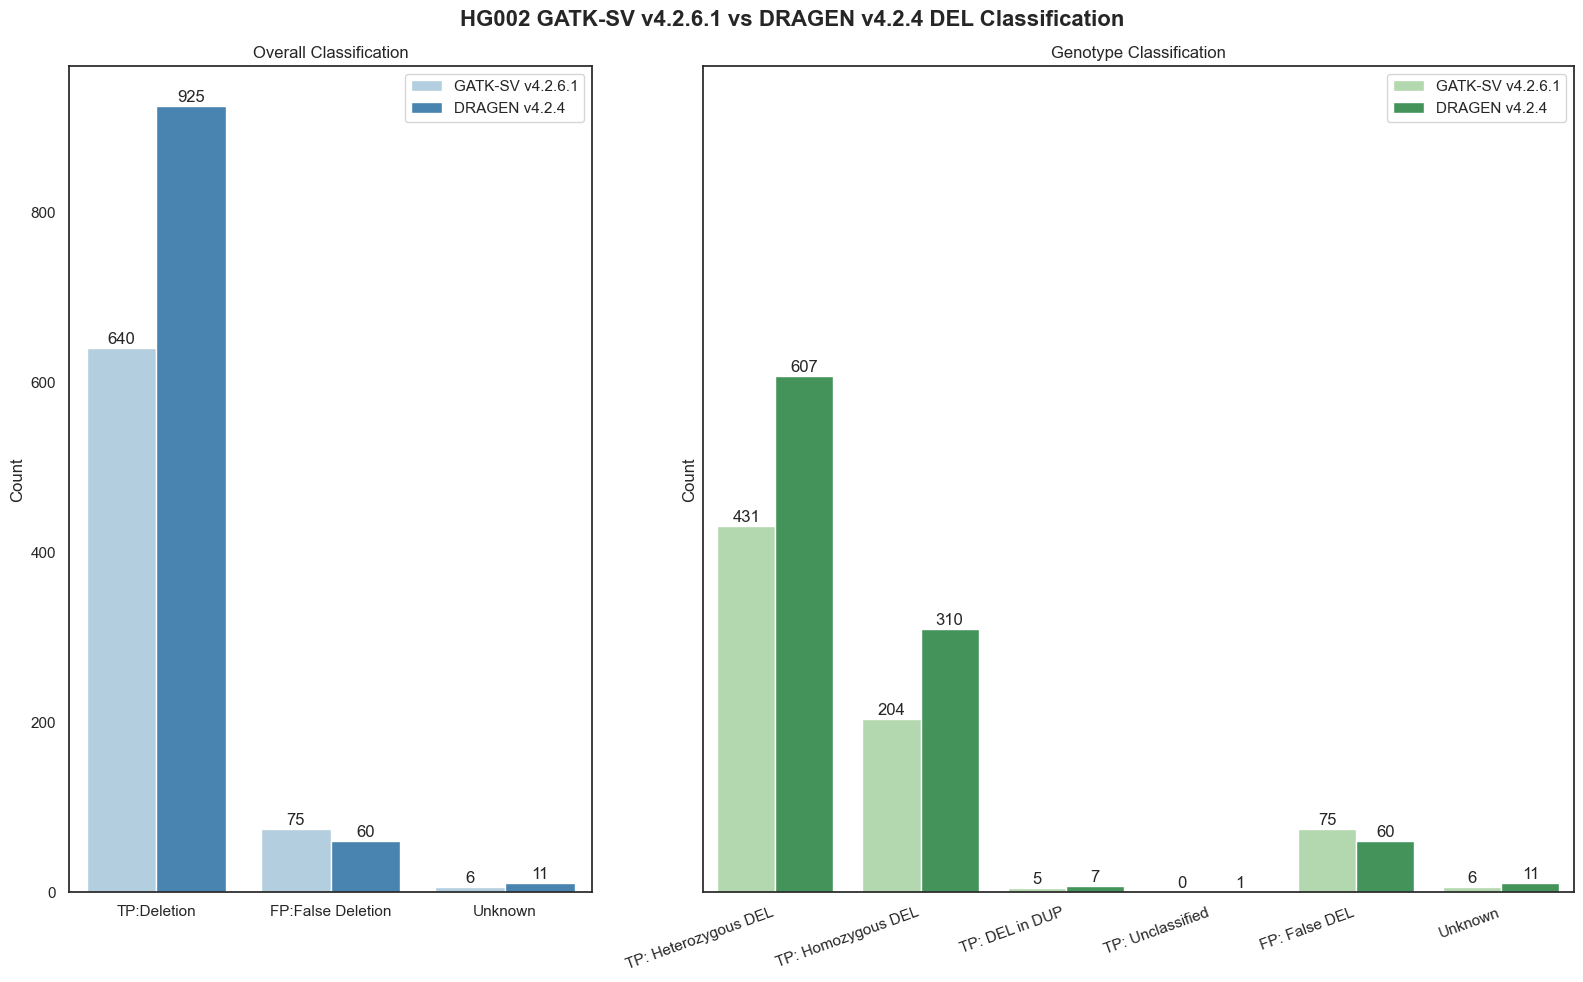

In [442]:
f, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharey=True, gridspec_kw={'width_ratios': [1.2, 2]})

maj_bar = sns.barplot(x=maj_count_df.index, y=maj_count_df['Count'], hue=maj_count_df['Caller'], ax=ax0, palette='Blues')
ax0.set_xlabel('')
ax0.set_ylabel('Count')
ax0.set_title('Overall Classification', fontsize=12)
ax0.legend(loc='upper right')

sub_bar = sns.barplot(x=sub_count_df.index, y=sub_count_df['Count'], hue=sub_count_df['Caller'], ax=ax1, palette='Greens')
ax1.set_xlabel('')
ax1.set_title('Genotype Classification', fontsize=12)
ax1.legend(loc='upper right')

plt.xticks(rotation=20, ha='right')

# Annotations for major classifications
for i, rect in enumerate(maj_bar.patches):
    height = rect.get_height()
    ax0.text(rect.get_x() + rect.get_width() / 2, height + 1, 
             f'{int(height)}', ha='center', va='bottom')

# Annotations for sub classifications
for i, rect in enumerate(sub_bar.patches):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 1, 
             f'{int(height)}', ha='center', va='bottom')

plt.suptitle('HG002 GATK-SV v4.2.6.1 vs DRAGEN v4.2.4 DEL Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('HG002_GATKSV_DRAGEN_DEL_Classification.png', dpi=300)

In [445]:
75/len(HG2_GATK_SV_pass_DEL_list)

0.10402219140083217

In [446]:
60/len(HG2_DRAGEN_pass_cnv)

0.054005400540054004